# Facebook Ads Conversions Prediction


_Using supervised machine learning algorithms to predict facebook ads conversions in the beauty treatment industry_


Note: Kernel Python 3 (Data Science) works well with this notebook. You will have the best experience running this within SageMaker Studio.


---

## Contents


#### 1) Business Problem
#### 2) Data Understanding

    2.1) Import libraries
    
    2.2) Connect to the meta marketing api
    
    2.3) Exploratory data analysis
    
#### 3) Data preparation
#### 4) Modelling and evaluation

    4.1) Linear Regression
    
    4.2) Autogluon
    
    4.3) XG Boost
    
    4.4) Sagemaker Auto Pilot
    
        4.4.1) Setting up the SageMaker Autopilot Job
        
        4.4.2) Launching the SageMaker Autopilot Job

        4.4.3) Tracking SageMaker Autopilot job progress

        4.4.4) SageMaker Autopilot results

        4.4.5) Data Exploration and Candidate Generation Notebooks

        4.4.6) Evaluate SageMaker Model Using Test Dataset

        4.4.7) Set up Transform Job

        4.4.8) Launch Transform Job

        4.4.9) Track Transform Job Status

        4.4.10) Evaluate the Inference Results
        
    4.5) Summary of results obtained
    
#### 5) Deployment

    5.1) Deploy best performing model
    5.2) Cleanup    



---

## 1) Business Problem

*   How many conversions (Chat messages triggered by ads) can advertisers obtain with different campaign settings (in terms of age, gender, budget and service offered in the ads) when running facebook ads in a given season of the year?


---

## 2) Data understanding



### 2.1 Import libraries

In [ ]:
import requests
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np
from sklearn import datasets
from sklearn.metrics import accuracy_score
import sagemaker
import boto3
from sagemaker import get_execution_role
import io
from urllib.parse import urlparse
import time

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.25.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [ ]:
!pip install xgboost

  Obtaining dependency information for xgboost from https://files.pythonhosted.org/packages/8c/3a/c9c5d4d5c49b132ef15ac7b5ccf56ef1c82efe36cd19414771762e97c00e/xgboost-1.7.6-py3-none-manylinux2014_x86_64.whl.metadata
  Obtaining dependency information for numpy from https://files.pythonhosted.org/packages/10/be/ae5bf4737cb79ba437879915791f6f26d92583c738d7d960ad94e5c36adf/numpy-1.24.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.3/200.3 MB 4.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 34.5 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: numpy
    Found existing installation: numpy 1.25.1
    Uninstalling numpy-1.25.1:
      Successfully uninstalled numpy-1.25.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
daal4py 2021.6.0 requires daal==2021.4.

In [ ]:
import xgboost as xgb

In [ ]:
!pip install -U pip
!pip install -U setuptools wheel
!pip install -U "mxnet<2.0.0" bokeh==2.0.1
!pip install autogluon --no-cache-dir
from autogluon.tabular import TabularDataset, TabularPredictor

  Obtaining dependency information for setuptools from https://files.pythonhosted.org/packages/4f/ab/0bcfebdfc3bfa8554b2b2c97a555569c4c1ebc74ea288741ea8326c51906/setuptools-68.1.2-py3-none-any.whl.metadata
  Using cached setuptools-68.1.2-py3-none-any.whl.metadata (6.2 kB)
  Obtaining dependency information for wheel from https://files.pythonhosted.org/packages/b8/8b/31273bf66016be6ad22bb7345c37ff350276cfd46e389a0c2ac5da9d9073/wheel-0.41.2-py3-none-any.whl.metadata
  Using cached wheel-0.41.2-py3-none-any.whl.metadata (2.2 kB)
Using cached setuptools-68.1.2-py3-none-any.whl (805 kB)
Using cached wheel-0.41.2-py3-none-any.whl (64 kB)
  Attempting uninstall: wheel
    Found existing installation: wheel 0.41.0
    Uninstalling wheel-0.41.0:
      Successfully uninstalled wheel-0.41.0
  Attempting uninstall: setuptools
    Found existing installation: setuptools 68.0.0
    Uninstalling setuptools-68.0.0:
      Successfully uninstalled setuptools-68.0.0
ERROR: pip's dependency resolver does

### 2.2 Connect to the meta marketing api

The code below extracts 3 years of real data from a facebook ads account, removes pagination and displays a dataframe. The data is broken down by month, campaign name, age and gender, and also contains the columns objective (campaign objective) and actions (conversions). The following video contains an explanation of how to connect to the meta marketing api using an access token:
https://www.youtube.com/watch?v=to4uTxSNo6Q&t=385s

In [ ]:
url = ("https://graph.facebook.com/v17.0/act_XXXXXXXXXX/insights"
       "?date_preset=maximum"
       "&level=campaign"
       "&fields=campaign_name,spend,objective,actions"
       "&time_increment=monthly"
       "&breakdowns=age,gender"
       "&access_token=XXXXXXXXXXXXXX")

# Fetch JSON data from the URL
response = requests.get(url)
data = response.json()

# Extract all data and pagination information
all_data = data.get('data', [])
while 'paging' in data and 'next' in data['paging']:
    response = requests.get(data['paging']['next'])
    data = response.json()
    all_data.extend(data.get('data', []))

# Create a Pandas DataFrame
df = pd.DataFrame(all_data)

# Display the DataFrame
df.head()

,campaign_name,spend,objective,actions,date_start,date_stop,age,gender
0,Mensajes hyper,31.25,MESSAGES,"[{'action_type': 'post_engagement', 'value': '...",2020-07-30,2020-07-31,25-34,female
1,Mensajes hyper,45.84,MESSAGES,[{'action_type': 'onsite_web_app_view_content'...,2020-07-30,2020-07-31,35-44,female
2,Mensajes hyper,79.69,MESSAGES,[{'action_type': 'onsite_web_app_view_content'...,2020-07-30,2020-07-31,45-54,female
3,Mensajes hyper,40.2,MESSAGES,[{'action_type': 'onsite_web_app_view_content'...,2020-07-30,2020-07-31,55-64,female
4,Mensajes Coolsculpting,1.34,MESSAGES,NaN,2020-07-30,2020-07-31,18-24,female


#### 2.3 Exploratory data analysis

Data types in the data frame:

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2892 entries, 0 to 2891
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   campaign_name  2892 non-null   object
 1   spend          2892 non-null   object
 2   objective      2892 non-null   object
 3   actions        2591 non-null   object
 4   date_start     2892 non-null   object
 5   date_stop      2892 non-null   object
 6   age            2892 non-null   object
 7   gender         2892 non-null   object
dtypes: object(8)
memory usage: 180.9+ KB


Number of rows and columns:

In [ ]:
df.shape

(2892, 8)

Remove rows where the campaign objective is not messages. This is because we are only interested in predicting conversions for campaigns that aim to generate a chat message.

In [ ]:
filtered_df = df[df['objective'] == 'MESSAGES']

# Display the filtered DataFrame
filtered_df.head()

,campaign_name,spend,objective,actions,date_start,date_stop,age,gender
0,Mensajes hyper,31.25,MESSAGES,"[{'action_type': 'post_engagement', 'value': '...",2020-07-30,2020-07-31,25-34,female
1,Mensajes hyper,45.84,MESSAGES,[{'action_type': 'onsite_web_app_view_content'...,2020-07-30,2020-07-31,35-44,female
2,Mensajes hyper,79.69,MESSAGES,[{'action_type': 'onsite_web_app_view_content'...,2020-07-30,2020-07-31,45-54,female
3,Mensajes hyper,40.2,MESSAGES,[{'action_type': 'onsite_web_app_view_content'...,2020-07-30,2020-07-31,55-64,female
4,Mensajes Coolsculpting,1.34,MESSAGES,NaN,2020-07-30,2020-07-31,18-24,female


Number of rows and columns (Only using rows with a "messages" campaign objective)

In [ ]:
filtered_df.shape

(1462, 8)

Below the distribution of rows for gender can be observed. There are a lot of unknown values!

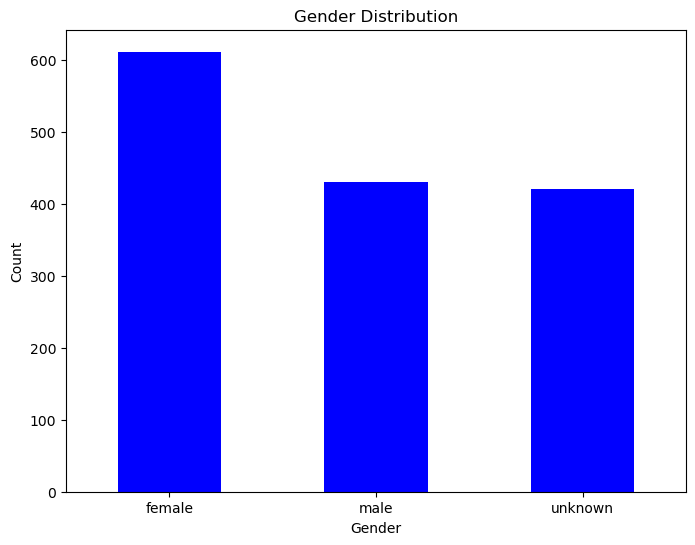

In [ ]:
# Count the occurrences of each gender value
gender_counts = filtered_df['gender'].value_counts()

# Create a bar chart
plt.figure(figsize=(8, 6))
gender_counts.plot(kind='bar', color='blue')
plt.title('Gender Distribution')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

Below the distribution of rows for age can be observed.

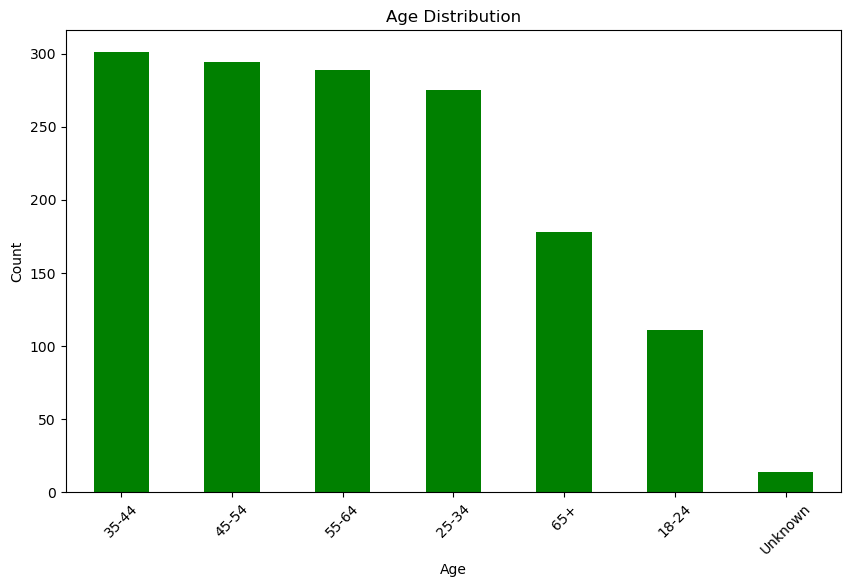

In [ ]:
# Count the occurrences of each age value
age_counts = filtered_df['age'].value_counts()

# Create a bar chart
plt.figure(figsize=(10, 6))
age_counts.plot(kind='bar', color='green')
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

Below the distribution of campaign names is shown. Most campaigns have on the name the cosmetic treatment which is being offered. This information could be used later for feature extraction.

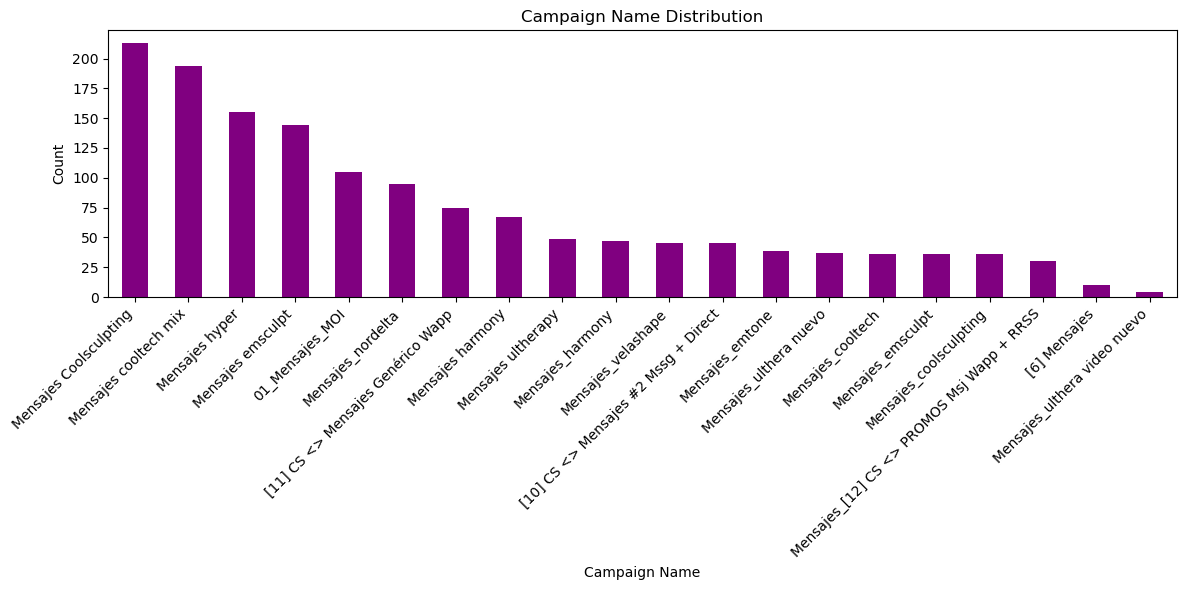

In [ ]:
# Count the occurrences of each campaign name
campaign_counts = filtered_df['campaign_name'].value_counts()

# Create a bar chart
plt.figure(figsize=(12, 6))
campaign_counts.plot(kind='bar', color='purple')
plt.title('Campaign Name Distribution')
plt.xlabel('Campaign Name')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

We will change the data type of the column 'spend' from string to numeric

In [ ]:
# Convert 'spend' column to numeric
filtered_df['spend'] = pd.to_numeric(filtered_df['spend'], errors='coerce')

/tmp/ipykernel_21/621778764.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['spend'] = pd.to_numeric(filtered_df['spend'], errors='coerce')


The following histogram shows how the distribution of spend is skewed to the right:

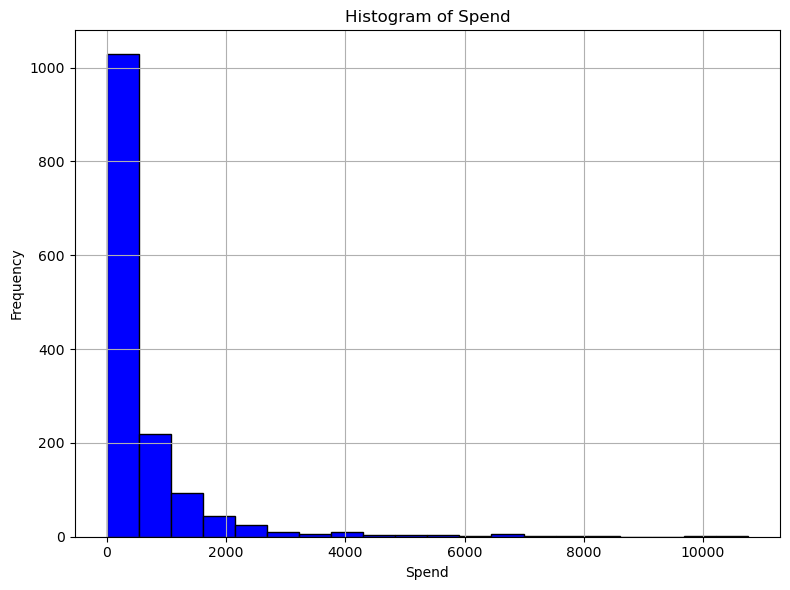

In [ ]:
# Create a histogram for the 'spend' column
plt.figure(figsize=(8, 6))
plt.hist(filtered_df['spend'], bins=20, color='blue', edgecolor='black')
plt.title('Histogram of Spend')
plt.xlabel('Spend')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()  # Adjusts layout for better visualization
plt.show()

There are 39 rows with 0 spend.

In [ ]:
spend_value_counts = filtered_df['spend'].value_counts()
spend_value_counts

0.000000      39
0.020000       5
0.060000       3
0.850000       2
40.110000      2
              ..
15.842377      1
301.135175     1
984.187643     1
19.772966      1
177.889348     1
Name: spend, Length: 1402, dtype: int64

Below we will see how a value of the actions column looks like:

In [ ]:
# Get the value of the first row in the 'actions' column
first_actions_value = filtered_df.loc[0, 'actions']

print("Value of the first row in 'actions' column:", first_actions_value)

Value of the first row in 'actions' column: [{'action_type': 'post_engagement', 'value': '1'}, {'action_type': 'page_engagement', 'value': '1'}, {'action_type': 'link_click', 'value': '1'}]


Instead of having values in this format we want the numerical value from onsite_conversion.messaging_conversation_started_7d, which is the type of conversion (Chat messages thanks to ads, that we want to measure)

In [ ]:
def process_actions(actions_list):
    if isinstance(actions_list, list):
        for action in actions_list:
            if 'action_type' in action and action['action_type'] == 'onsite_conversion.messaging_conversation_started_7d':
                return int(action['value'])
    return 0

# Apply the custom function to the 'actions' column
filtered_df['actions'] = filtered_df['actions'].apply(process_actions)

/tmp/ipykernel_21/765992555.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['actions'] = filtered_df['actions'].apply(process_actions)


The dataframe below shows how our function worked.

In [ ]:
filtered_df

,campaign_name,spend,objective,actions,date_start,date_stop,age,gender
0,Mensajes hyper,31.25,MESSAGES,0,2020-07-30,2020-07-31,25-34,female
1,Mensajes hyper,45.84,MESSAGES,0,2020-07-30,2020-07-31,35-44,female
2,Mensajes hyper,79.69,MESSAGES,0,2020-07-30,2020-07-31,45-54,female
3,Mensajes hyper,40.20,MESSAGES,0,2020-07-30,2020-07-31,55-64,female
4,Mensajes Coolsculpting,1.34,MESSAGES,0,2020-07-30,2020-07-31,18-24,female
...,...,...,...,...,...,...,...,...
2212,01_Mensajes_MOI,1195.72,MESSAGES,3,2022-09-01,2022-09-30,55-64,male
2213,01_Mensajes_MOI,62.54,MESSAGES,0,2022-09-01,2022-09-30,55-64,unknown
2214,01_Mensajes_MOI,4207.56,MESSAGES,5,2022-09-01,2022-09-30,65+,female
2215,01_Mensajes_MOI,760.61,MESSAGES,1,2022-09-01,2022-09-30,65+,male


We will also change the actions column to numeric format

In [ ]:
# Convert 'actions' column to numeric
filtered_df['actions'] = pd.to_numeric(filtered_df['actions'], errors='coerce')

/tmp/ipykernel_21/895461833.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['actions'] = pd.to_numeric(filtered_df['actions'], errors='coerce')


We can see how the actions column is skewed to the right

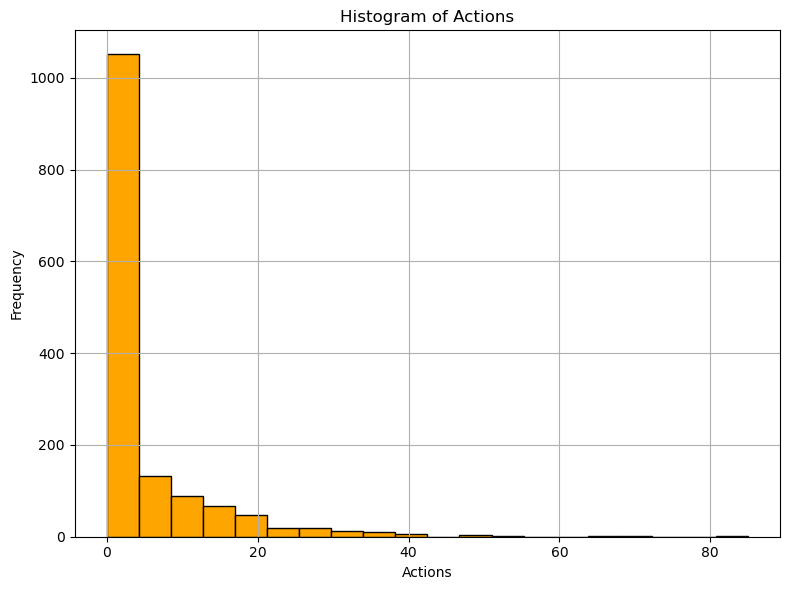

In [ ]:
# Create a histogram for the 'actions' column
plt.figure(figsize=(8, 6))
plt.hist(filtered_df['actions'], bins=20, color='orange', edgecolor='black')
plt.title('Histogram of Actions')
plt.xlabel('Actions')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()  # Adjusts layout for better visualization
plt.show()

Next we change the name of the dataframe for convenience

In [ ]:
df = filtered_df

Currently we have two columns with start date and end date. We will just keep one column, change it to date format, and show only the month number.

In [ ]:
df['date_start'] = pd.to_datetime(df['date_start'])
df['date_stop'] = pd.to_datetime(df['date_stop'])

# Extract the month from 'date_start' and create a new column
df['start_month'] = df['date_start'].dt.month

# Drop the original 'date_start' and 'date_stop' columns
df.drop(['date_start', 'date_stop'], axis=1, inplace=True)
df

,campaign_name,spend,objective,actions,age,gender,start_month
0,Mensajes hyper,31.25,MESSAGES,0,25-34,female,7
1,Mensajes hyper,45.84,MESSAGES,0,35-44,female,7
2,Mensajes hyper,79.69,MESSAGES,0,45-54,female,7
3,Mensajes hyper,40.20,MESSAGES,0,55-64,female,7
4,Mensajes Coolsculpting,1.34,MESSAGES,0,18-24,female,7
...,...,...,...,...,...,...,...
2212,01_Mensajes_MOI,1195.72,MESSAGES,3,55-64,male,9
2213,01_Mensajes_MOI,62.54,MESSAGES,0,55-64,unknown,9
2214,01_Mensajes_MOI,4207.56,MESSAGES,5,65+,female,9
2215,01_Mensajes_MOI,760.61,MESSAGES,1,65+,male,9


Everything seems to be ok for the months distribution. There is no month with missing values.

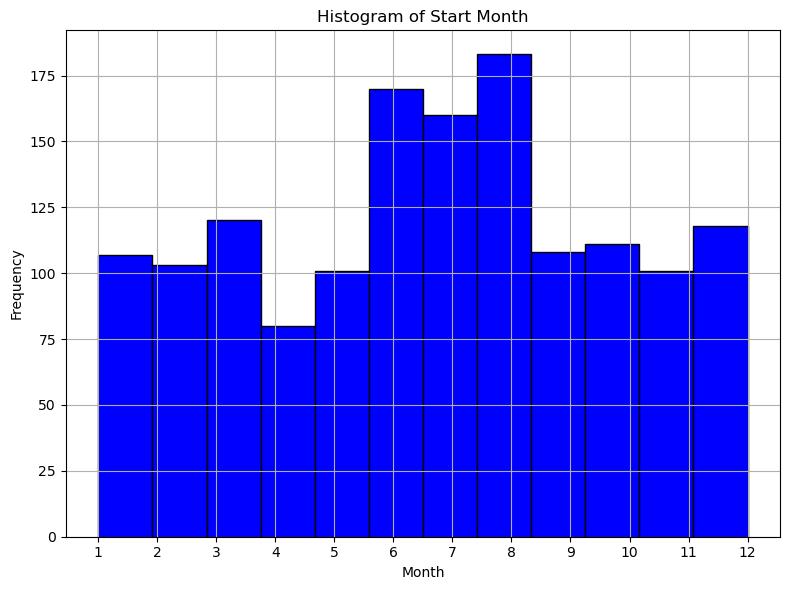

In [ ]:
# Create a histogram for the 'start_month' column
plt.figure(figsize=(8, 6))
plt.hist(df['start_month'], bins=12, color='blue', edgecolor='black')
plt.title('Histogram of Start Month')
plt.xlabel('Month')
plt.ylabel('Frequency')
plt.xticks(range(1, 13))  # Setting x-axis ticks to represent months
plt.grid(True)
plt.tight_layout()  # Adjusts layout for better visualization
plt.show()

In [ ]:
# Get value counts for the 'start_month' column
start_month_value_counts = df['start_month'].value_counts()

print(start_month_value_counts)

8     183
6     170
7     160
3     120
12    118
10    111
9     108
1     107
2     103
11    101
5     101
4      80
Name: start_month, dtype: int64


It can be observed how as the amount spent increases, the amount of conversions tends to increase.

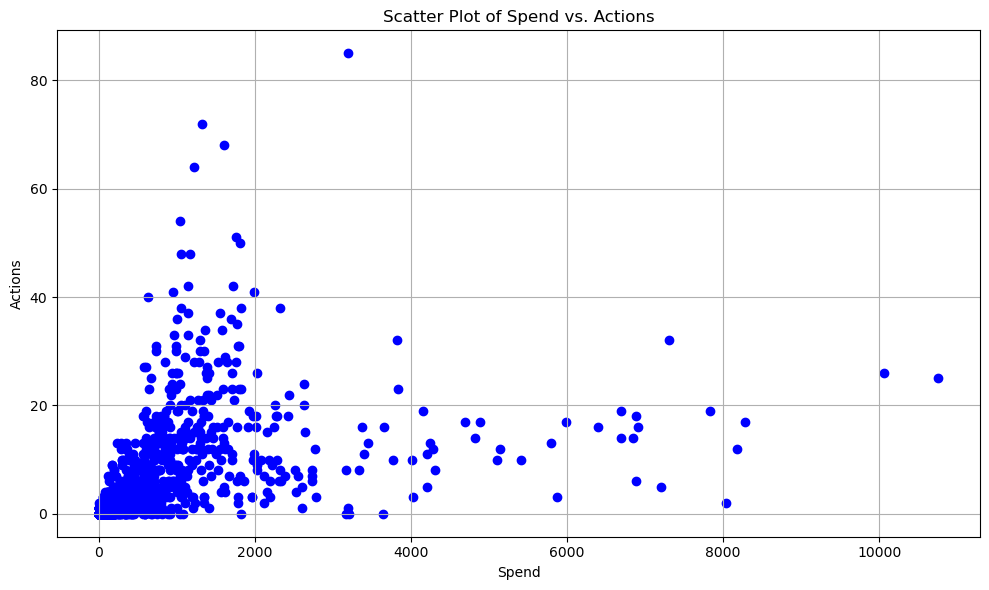

In [ ]:
# Assuming 'df' is your DataFrame

# Create a scatter plot for 'spend' and 'actions'
plt.figure(figsize=(10, 6))
plt.scatter(df['spend'], df['actions'], color='blue', marker='o')
plt.title('Scatter Plot of Spend vs. Actions')
plt.xlabel('Spend')
plt.ylabel('Actions')
plt.grid(True)
plt.tight_layout()  # Adjusts layout for better visualization
plt.show()

---

## 3) Data preparation



We will perform below a one-hot encoding for 'gender' columns.

In [ ]:
# Perform one-hot encoding for 'gender' columns
df = pd.get_dummies(df, columns=['gender'])

In [ ]:
df

,campaign_name,spend,objective,actions,age,start_month,gender_female,gender_male,gender_unknown
0,Mensajes hyper,31.25,MESSAGES,0,25-34,7,1,0,0
1,Mensajes hyper,45.84,MESSAGES,0,35-44,7,1,0,0
2,Mensajes hyper,79.69,MESSAGES,0,45-54,7,1,0,0
3,Mensajes hyper,40.20,MESSAGES,0,55-64,7,1,0,0
4,Mensajes Coolsculpting,1.34,MESSAGES,0,18-24,7,1,0,0
...,...,...,...,...,...,...,...,...,...
2212,01_Mensajes_MOI,1195.72,MESSAGES,3,55-64,9,0,1,0
2213,01_Mensajes_MOI,62.54,MESSAGES,0,55-64,9,0,0,1
2214,01_Mensajes_MOI,4207.56,MESSAGES,5,65+,9,1,0,0
2215,01_Mensajes_MOI,760.61,MESSAGES,1,65+,9,0,1,0


We will drop the objective column because it has no variability.

In [ ]:
df = df.drop(columns=['objective'])


Since the beauty treatments industry is seasonal, we will change numbers to the name of each season

In [ ]:
def map_to_season(month):
    if month in [1, 2, 3]:
        return "summer"
    elif month in [4, 5, 6]:
        return "autumn"
    elif month in [7, 8, 9]:
        return "winter"
    elif month in [10, 11, 12]:
        return "spring"
    else:
        return None

# Apply the function to create a new column "season"
df['season'] = df['start_month'].apply(map_to_season)

In [ ]:
df

,campaign_name,spend,actions,age,start_month,gender_female,gender_male,gender_unknown,season
0,Mensajes hyper,31.25,0,25-34,7,1,0,0,winter
1,Mensajes hyper,45.84,0,35-44,7,1,0,0,winter
2,Mensajes hyper,79.69,0,45-54,7,1,0,0,winter
3,Mensajes hyper,40.20,0,55-64,7,1,0,0,winter
4,Mensajes Coolsculpting,1.34,0,18-24,7,1,0,0,winter
...,...,...,...,...,...,...,...,...,...
2212,01_Mensajes_MOI,1195.72,3,55-64,9,0,1,0,winter
2213,01_Mensajes_MOI,62.54,0,55-64,9,0,0,1,winter
2214,01_Mensajes_MOI,4207.56,5,65+,9,1,0,0,winter
2215,01_Mensajes_MOI,760.61,1,65+,9,0,1,0,winter


Drop the start_month column, since with season is enough

In [ ]:
df = df.drop(columns=['start_month'])

In [ ]:
df

,campaign_name,spend,actions,age,gender_female,gender_male,gender_unknown,season
0,Mensajes hyper,31.25,0,25-34,1,0,0,winter
1,Mensajes hyper,45.84,0,35-44,1,0,0,winter
2,Mensajes hyper,79.69,0,45-54,1,0,0,winter
3,Mensajes hyper,40.20,0,55-64,1,0,0,winter
4,Mensajes Coolsculpting,1.34,0,18-24,1,0,0,winter
...,...,...,...,...,...,...,...,...
2212,01_Mensajes_MOI,1195.72,3,55-64,0,1,0,winter
2213,01_Mensajes_MOI,62.54,0,55-64,0,0,1,winter
2214,01_Mensajes_MOI,4207.56,5,65+,1,0,0,winter
2215,01_Mensajes_MOI,760.61,1,65+,0,1,0,winter


Normalize the amount spent

In [ ]:

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Normalize the 'spend' column
df['spend_normalized'] = scaler.fit_transform(df[['spend']])

Drop the amount spent column that is not normalized

In [ ]:
df = df.drop(columns=['spend'])
df

,campaign_name,actions,age,gender_female,gender_male,gender_unknown,season,spend_normalized
0,Mensajes hyper,0,25-34,1,0,0,winter,0.002906
1,Mensajes hyper,0,35-44,1,0,0,winter,0.004263
2,Mensajes hyper,0,45-54,1,0,0,winter,0.007411
3,Mensajes hyper,0,55-64,1,0,0,winter,0.003739
4,Mensajes Coolsculpting,0,18-24,1,0,0,winter,0.000125
...,...,...,...,...,...,...,...,...
2212,01_Mensajes_MOI,3,55-64,0,1,0,winter,0.111199
2213,01_Mensajes_MOI,0,55-64,0,0,1,winter,0.005816
2214,01_Mensajes_MOI,5,65+,1,0,0,winter,0.391294
2215,01_Mensajes_MOI,1,65+,0,1,0,winter,0.070735


Change the ages ranges from categorical to numerical (A value in the middle of the ranges will be assigned)

In [ ]:
age_mapping = {
    "18-24": 20,
    "25-34": 30,
    "35-44": 40,
    "45-54": 50,
    "55-64": 60,
    "65+": 70
}

df['age'] = df['age'].replace(age_mapping)

In [ ]:
df

,campaign_name,actions,age,gender_female,gender_male,gender_unknown,season,spend_normalized
0,Mensajes hyper,0,30,1,0,0,winter,0.002906
1,Mensajes hyper,0,40,1,0,0,winter,0.004263
2,Mensajes hyper,0,50,1,0,0,winter,0.007411
3,Mensajes hyper,0,60,1,0,0,winter,0.003739
4,Mensajes Coolsculpting,0,20,1,0,0,winter,0.000125
...,...,...,...,...,...,...,...,...
2212,01_Mensajes_MOI,3,60,0,1,0,winter,0.111199
2213,01_Mensajes_MOI,0,60,0,0,1,winter,0.005816
2214,01_Mensajes_MOI,5,70,1,0,0,winter,0.391294
2215,01_Mensajes_MOI,1,70,0,1,0,winter,0.070735


Perform one hot-encoding for age values

In [ ]:
df = pd.get_dummies(df, columns=["age"], prefix=["age"])
df

,campaign_name,actions,gender_female,gender_male,gender_unknown,season,spend_normalized,age_20,age_30,age_40,age_50,age_60,age_70,age_Unknown
0,Mensajes hyper,0,1,0,0,winter,0.002906,0,1,0,0,0,0,0
1,Mensajes hyper,0,1,0,0,winter,0.004263,0,0,1,0,0,0,0
2,Mensajes hyper,0,1,0,0,winter,0.007411,0,0,0,1,0,0,0
3,Mensajes hyper,0,1,0,0,winter,0.003739,0,0,0,0,1,0,0
4,Mensajes Coolsculpting,0,1,0,0,winter,0.000125,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2212,01_Mensajes_MOI,3,0,1,0,winter,0.111199,0,0,0,0,1,0,0
2213,01_Mensajes_MOI,0,0,0,1,winter,0.005816,0,0,0,0,1,0,0
2214,01_Mensajes_MOI,5,1,0,0,winter,0.391294,0,0,0,0,0,1,0
2215,01_Mensajes_MOI,1,0,1,0,winter,0.070735,0,0,0,0,0,1,0


Perform one hot encodings for season

In [ ]:
df = pd.get_dummies(df, columns=["season"], prefix=["season"])
df

,campaign_name,actions,gender_female,gender_male,gender_unknown,spend_normalized,age_20,age_30,age_40,age_50,age_60,age_70,age_Unknown,season_autumn,season_spring,season_summer,season_winter
0,Mensajes hyper,0,1,0,0,0.002906,0,1,0,0,0,0,0,0,0,0,1
1,Mensajes hyper,0,1,0,0,0.004263,0,0,1,0,0,0,0,0,0,0,1
2,Mensajes hyper,0,1,0,0,0.007411,0,0,0,1,0,0,0,0,0,0,1
3,Mensajes hyper,0,1,0,0,0.003739,0,0,0,0,1,0,0,0,0,0,1
4,Mensajes Coolsculpting,0,1,0,0,0.000125,1,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2212,01_Mensajes_MOI,3,0,1,0,0.111199,0,0,0,0,1,0,0,0,0,0,1
2213,01_Mensajes_MOI,0,0,0,1,0.005816,0,0,0,0,1,0,0,0,0,0,1
2214,01_Mensajes_MOI,5,1,0,0,0.391294,0,0,0,0,0,1,0,0,0,0,1
2215,01_Mensajes_MOI,1,0,1,0,0.070735,0,0,0,0,0,1,0,0,0,0,1


Most of the campaign names contain the type of treatment offered in the ad in the campaign name. Hence, we will assign a category to the campaign, depending on the treatment offered.

In [ ]:
campaign_name_counts = df['campaign_name'].value_counts()

print(campaign_name_counts)

Mensajes Coolsculpting                        213
Mensajes cooltech mix                         194
Mensajes hyper                                155
Mensajes emsculpt                             144
01_Mensajes_MOI                               105
Mensajes_nordelta                              95
[11] CS <> Mensajes Genérico Wapp              75
Mensajes harmony                               67
Mensajes ultherapy                             49
Mensajes_harmony                               47
Mensajes_velashape                             45
[10] CS <> Mensajes #2 Mssg + Direct           45
Mensajes_emtone                                39
Mensajes_ulthera nuevo                         37
Mensajes_cooltech                              36
Mensajes_emsculpt                              36
Mensajes_coolsculpting                         36
Mensajes_[12] CS <> PROMOS Msj Wapp + RRSS     30
[6] Mensajes                                   10
Mensajes_ulthera video nuevo                    4


In [ ]:
# List of keywords and their replacements
replacements = {
    "coolsculpting": "coolsculpting",
    "cooltech": "cooltech",
    "hyper": "hyper",
    "emsculpt": "emsculpt",
    "harmony": "harmony",
    "ulthera": "ultherapy",
    "velashape": "velashape",
    "emtone": "emtone"
}

# Function to perform replacements
def replace_keywords(value):
    for keyword, replacement in replacements.items():
        if keyword in value.lower():
            return replacement
    return "other"

# Apply the function to create a new 'campaign_name_clean' column
df['campaign_name_clean'] = df['campaign_name'].apply(replace_keywords)

# Display value counts for the cleaned campaign names
campaign_name_clean_counts = df['campaign_name_clean'].value_counts()
print(campaign_name_clean_counts)

other            360
coolsculpting    249
cooltech         230
emsculpt         180
hyper            155
harmony          114
ultherapy         90
velashape         45
emtone            39
Name: campaign_name_clean, dtype: int64


In [ ]:
df

,campaign_name,actions,gender_female,gender_male,gender_unknown,spend_normalized,age_20,age_30,age_40,age_50,age_60,age_70,age_Unknown,season_autumn,season_spring,season_summer,season_winter,campaign_name_clean
0,Mensajes hyper,0,1,0,0,0.002906,0,1,0,0,0,0,0,0,0,0,1,hyper
1,Mensajes hyper,0,1,0,0,0.004263,0,0,1,0,0,0,0,0,0,0,1,hyper
2,Mensajes hyper,0,1,0,0,0.007411,0,0,0,1,0,0,0,0,0,0,1,hyper
3,Mensajes hyper,0,1,0,0,0.003739,0,0,0,0,1,0,0,0,0,0,1,hyper
4,Mensajes Coolsculpting,0,1,0,0,0.000125,1,0,0,0,0,0,0,0,0,0,1,coolsculpting
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2212,01_Mensajes_MOI,3,0,1,0,0.111199,0,0,0,0,1,0,0,0,0,0,1,other
2213,01_Mensajes_MOI,0,0,0,1,0.005816,0,0,0,0,1,0,0,0,0,0,1,other
2214,01_Mensajes_MOI,5,1,0,0,0.391294,0,0,0,0,0,1,0,0,0,0,1,other
2215,01_Mensajes_MOI,1,0,1,0,0.070735,0,0,0,0,0,1,0,0,0,0,1,other


We will also remove the campaign_name column

In [ ]:
df = df.drop(columns=['campaign_name'])


Perform one-hot encodings for campaign_name_clean

In [ ]:
encoded_campaigns = pd.get_dummies(df['campaign_name_clean'], prefix='campaign')

# Concatenate the encoded columns to the original DataFrame
df = pd.concat([df, encoded_campaigns], axis=1)
df

,actions,gender_female,gender_male,gender_unknown,spend_normalized,age_20,age_30,age_40,age_50,age_60,...,campaign_name_clean,campaign_coolsculpting,campaign_cooltech,campaign_emsculpt,campaign_emtone,campaign_harmony,campaign_hyper,campaign_other,campaign_ultherapy,campaign_velashape
0,0,1,0,0,0.002906,0,1,0,0,0,...,hyper,0,0,0,0,0,1,0,0,0
1,0,1,0,0,0.004263,0,0,1,0,0,...,hyper,0,0,0,0,0,1,0,0,0
2,0,1,0,0,0.007411,0,0,0,1,0,...,hyper,0,0,0,0,0,1,0,0,0
3,0,1,0,0,0.003739,0,0,0,0,1,...,hyper,0,0,0,0,0,1,0,0,0
4,0,1,0,0,0.000125,1,0,0,0,0,...,coolsculpting,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2212,3,0,1,0,0.111199,0,0,0,0,1,...,other,0,0,0,0,0,0,1,0,0
2213,0,0,0,1,0.005816,0,0,0,0,1,...,other,0,0,0,0,0,0,1,0,0
2214,5,1,0,0,0.391294,0,0,0,0,0,...,other,0,0,0,0,0,0,1,0,0
2215,1,0,1,0,0.070735,0,0,0,0,0,...,other,0,0,0,0,0,0,1,0,0


In [ ]:
df = df.drop(columns=['campaign_name_clean'])
df

,actions,gender_female,gender_male,gender_unknown,spend_normalized,age_20,age_30,age_40,age_50,age_60,...,season_winter,campaign_coolsculpting,campaign_cooltech,campaign_emsculpt,campaign_emtone,campaign_harmony,campaign_hyper,campaign_other,campaign_ultherapy,campaign_velashape
0,0,1,0,0,0.002906,0,1,0,0,0,...,1,0,0,0,0,0,1,0,0,0
1,0,1,0,0,0.004263,0,0,1,0,0,...,1,0,0,0,0,0,1,0,0,0
2,0,1,0,0,0.007411,0,0,0,1,0,...,1,0,0,0,0,0,1,0,0,0
3,0,1,0,0,0.003739,0,0,0,0,1,...,1,0,0,0,0,0,1,0,0,0
4,0,1,0,0,0.000125,1,0,0,0,0,...,1,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2212,3,0,1,0,0.111199,0,0,0,0,1,...,1,0,0,0,0,0,0,1,0,0
2213,0,0,0,1,0.005816,0,0,0,0,1,...,1,0,0,0,0,0,0,1,0,0
2214,5,1,0,0,0.391294,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0
2215,1,0,1,0,0.070735,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0


Create a correlation heatmap that displays correlations between features. We can see that gender and spend are the most correlated features to actions. Also age, ultherapy, hyper and winter show some degree (lower) of correlations to actions.

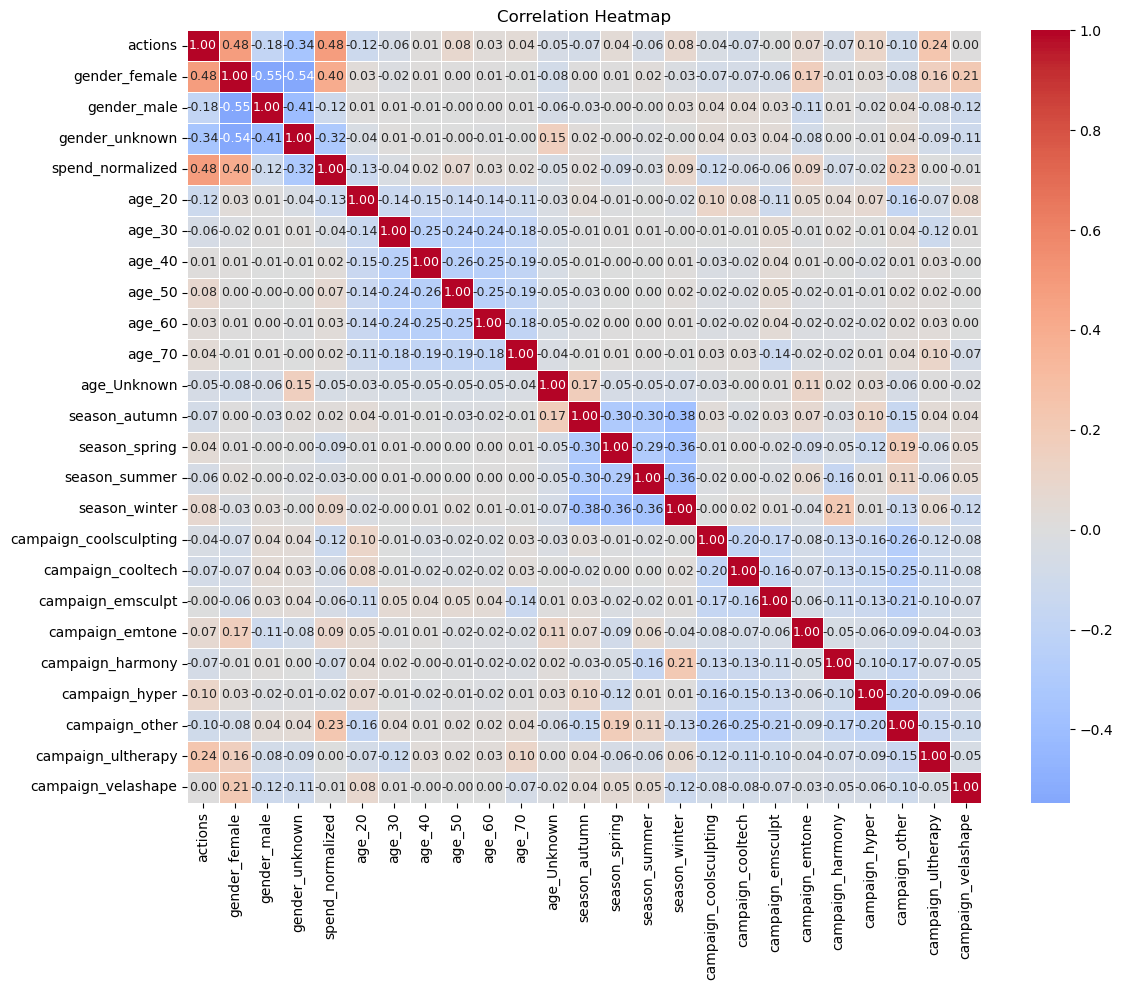

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the correlation matrix
corr_matrix = df.corr()

# Create a larger figure and adjust annotation font size and spacing
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", center=0, annot_kws={"size": 9}, linewidths=0.5)
plt.title("Correlation Heatmap")
plt.tight_layout()  # Adjust layout to prevent cutoff labels
plt.show()


In [ ]:
df

,actions,gender_female,gender_male,gender_unknown,spend_normalized,age_20,age_30,age_40,age_50,age_60,...,season_winter,campaign_coolsculpting,campaign_cooltech,campaign_emsculpt,campaign_emtone,campaign_harmony,campaign_hyper,campaign_other,campaign_ultherapy,campaign_velashape
0,0,1,0,0,0.002906,0,1,0,0,0,...,1,0,0,0,0,0,1,0,0,0
1,0,1,0,0,0.004263,0,0,1,0,0,...,1,0,0,0,0,0,1,0,0,0
2,0,1,0,0,0.007411,0,0,0,1,0,...,1,0,0,0,0,0,1,0,0,0
3,0,1,0,0,0.003739,0,0,0,0,1,...,1,0,0,0,0,0,1,0,0,0
4,0,1,0,0,0.000125,1,0,0,0,0,...,1,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2212,3,0,1,0,0.111199,0,0,0,0,1,...,1,0,0,0,0,0,0,1,0,0
2213,0,0,0,1,0.005816,0,0,0,0,1,...,1,0,0,0,0,0,0,1,0,0
2214,5,1,0,0,0.391294,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0
2215,1,0,1,0,0.070735,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0


---
## 4) Modelling and evaluation

### 4.1 Linear Regression

We will start by trying a linear regression model.

In [ ]:
# Separate features and target variable
X = df.drop("actions", axis=1)
y = df["actions"]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the linear regression model
model = LinearRegression()

# Fit the model on the training data
model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = model.predict(X_test)

# Calculate the mean squared error of the test data
mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error:", mae)

Mean Absolute Error: 3.762372013651877


In [ ]:
# Calculate the r2 on the test data
r2 = r2_score(y_test, y_pred)
print("R-squared:", r2)

R-squared: 0.5035409485677727


We already calculated these metrics for the test datasets. Now we will calculate the training dataset.

In [ ]:
y_train_pred = model.predict(X_train)

# Calculate training metrics
train_mae = mean_absolute_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

print("Training Mean Absolute Error:", train_mae)
print("Training R-squared:", train_r2)

Training Mean Absolute Error: 3.8882591958939265
Training R-squared: 0.4228965515016807


These values are not bad, but we will try some more complex models using autogluon to try to improve them.

### 4.2 Autogluon

In [ ]:
# Split your data with these ratios: train: 0.8 | test: 0.2
dfd_train, dfd_test = train_test_split(df, test_size=0.2, random_state=0)

In [ ]:
# How does the model perform on the training dataset and default model parameters?
# Using the hyperparameters in the requirements, is there improvement?
# Remember we use the test dataset to score the model
# Since we are using a different eval_metric, we'll need to assign the problem_type
predictor = TabularPredictor(
    label="actions", problem_type="regression", eval_metric="r2"
).fit(
    train_data=dfd_train,
    time_limit=600,
    presets="best_quality",
)

No path specified. Models will be saved in: "AutogluonModels/ag-20230831_051944/"
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=20
Beginning AutoGluon training ... Time limit = 600s
AutoGluon will save models to "AutogluonModels/ag-20230831_051944/"
AutoGluon Version:  0.8.2
Python Version:     3.10.6
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Tue Jun 27 21:49:00 UTC 2023
Disk Space Avail:   9223372036.53 GB / 9223372036.85 GB (100.0%)
Train Data Rows:    1169
Train Data Columns: 24
Label Column: actions
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    2880.13 MB
	Train Data (Original)  Memory Usage: 0.04 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features

The code below shows the r-squared score and mean absolute error on the test datasets:

In [ ]:
# Use the trained predictor to make predictions on the test dataset
predictions = predictor.predict(dfd_test)

# Get the true labels from the test dataset
true_labels = dfd_test['actions']

# Calculate the R-squared score
from sklearn.metrics import r2_score
r2 = r2_score(true_labels, predictions)

print("R-squared Score on Test Data:", r2)


R-squared Score on Test Data: 0.594537421425203


In [ ]:

# Calculate the Mean Absolute Error
mae = mean_absolute_error(true_labels, predictions)
print("Mean absolute error on Test Data:", mae)

Mean absolute error on Test Data: 2.234362465717652


In [ ]:
# Output the fit summary of the training run
predictor.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                     model  score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0      WeightedEnsemble_L3   0.743035       1.307935  314.550277                0.000598           0.383622            3       True         22
1          CatBoost_BAG_L2   0.735043       0.974944  236.852599                0.028530          30.136745            2       True         16
2      WeightedEnsemble_L2   0.730520       0.363145  143.554379                0.000529           0.466339            2       True         12
3   NeuralNetFastAI_BAG_L2   0.721386       1.085367  242.553076                0.138953          35.837222            2       True         18
4     ExtraTreesMSE_BAG_L2   0.718642       1.107257  208.396098                0.160843           1.680243            2       True         17
5        LightGBMXT_BAG_L2   0.715945       1.440456  234.099693                

/opt/conda/lib/python3.10/site-packages/autogluon/core/utils/plots.py:169: UserWarning: AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"
  warnings.warn('AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"')


{'model_types': {'KNeighborsUnif_BAG_L1': 'StackerEnsembleModel_KNN',
  'KNeighborsDist_BAG_L1': 'StackerEnsembleModel_KNN',
  'LightGBMXT_BAG_L1': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L1': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L1': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L1': 'StackerEnsembleModel_XT',
  'NeuralNetFastAI_BAG_L1': 'StackerEnsembleModel_NNFastAiTabular',
  'XGBoost_BAG_L1': 'StackerEnsembleModel_XGBoost',
  'NeuralNetTorch_BAG_L1': 'StackerEnsembleModel_TabularNeuralNetTorch',
  'LightGBMLarge_BAG_L1': 'StackerEnsembleModel_LGB',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel',
  'LightGBMXT_BAG_L2': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L2': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L2': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L2': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L2': 'StackerEnsembleModel_XT',
  'NeuralNetFastAI_BAG_L2': 'StackerEnsembleModel_NNFa

<AxesSubplot:xlabel='model'>

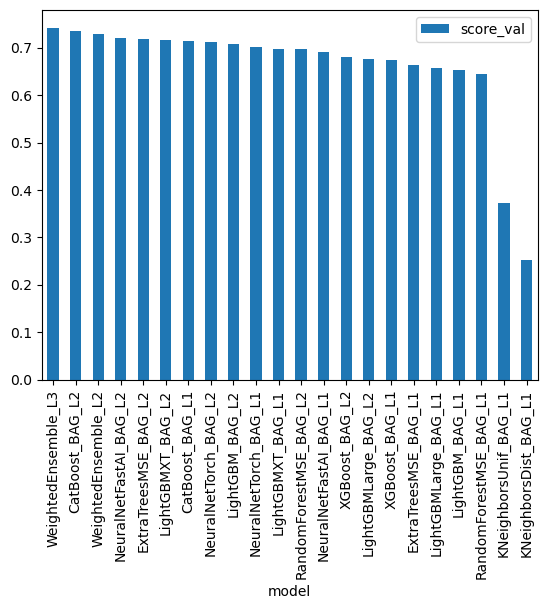

In [ ]:
# Output the model's `score_val` in a bar chart to compare performance
predictor.leaderboard(silent=True).plot(kind="bar", x="model", y="score_val")

The results have greatly improved, obtaining better results of r2 in the training dataset with the model WeightedEnsemble_L3. The fact that the best performing models where WeightedEnsemble_L3, CatBoost_BAG_L2 and LightGBMXT_BAG_L2, which are ensemble and boosting models, can be explained by the fact that these models are good at working with skewed datasets. It's important to consider that our target variable (actions), and the amount spent (which is the most correlated value with the target variable), have distributions that are skewed to the right. These models are robust to outliers and can handle them effectively. Also, skewed distributions often indicate complex and non-linear relationships between variables. Boosting algorithms are designed to capture these non-linearities, making them well-suited for scenarios where the relationships are not linear.

In [ ]:
# Make predictions using the trained model on the test dataset
predictions = predictor.predict(dfd_test)
predictions

607      2.038442
1601     0.100091
528      0.381810
332      1.151414
742     11.412725
          ...    
509      6.579350
1663     0.059285
563     20.865210
74       1.148813
594      0.092486
Name: actions, Length: 293, dtype: float32

### 4.3 XG Boost

Now we will try to fine-tune XG Boost, which was a good performing model

In [ ]:
# Load your train/test dataframe into DMatrix
dtrain = xgb.DMatrix(
    dfd_train.loc[:, dfd_train.columns != "actions"], label=dfd_train["actions"]
)
dtest = xgb.DMatrix(
    dfd_test.loc[:, dfd_test.columns != "actions"], label=dfd_test["actions"]
)

In [ ]:
# How does the model perform on the training dataset and default model parameters?
# Using the hyperparameters in the requirements, is there improvement?
# Remember we use the test dataset to score the model
param = {
    "max_depth": 2,
    "eta": 0.03,
    "gamma": 0.09,
    "colsample_bytree": 0.5,
    "objective": "reg:squarederror",
}
num_round = 100
bst = xgb.train(param, dtrain, num_round)

In [ ]:
# xgboost is not scikit learn, so you'll need to do predictions using their API
preds = bst.predict(dtest)

In [ ]:
# R2 score using scikit learn function for regression metric
r2_score(dfd_test["actions"], preds)

0.5654948492150249

In [ ]:
# Calculate Mean Absolute Error
mae = mean_absolute_error(dfd_test["actions"], preds)
print("Mean Absolute Error:", mae)

Mean Absolute Error: 2.7780983991310664


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

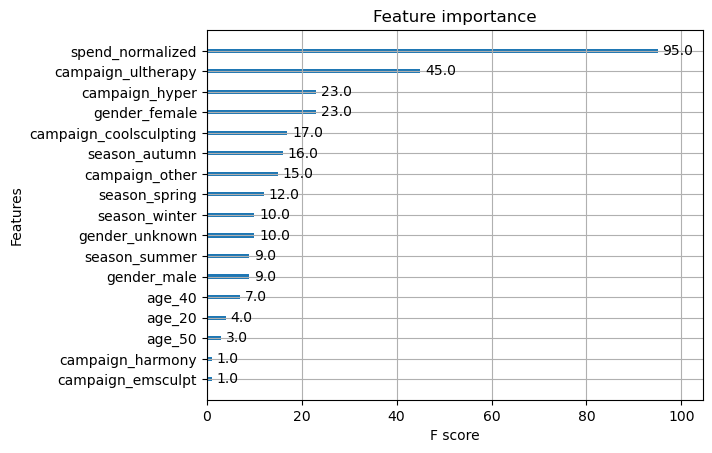

In [ ]:
# Plot the importance of the features based on fitted trees
xgb.plot_importance(bst)

### 4.4 Sagemaker Auto Pilot

In [ ]:
import sagemaker
import boto3
from sagemaker import get_execution_role

region = boto3.Session().region_name

session = sagemaker.Session()

# You can modify the following to use a bucket of your choosing
bucket = session.default_bucket()
prefix = "sagemaker/DEMO-fb-ads-predictor"

role = get_execution_role()

# This is the client we will use to interact with SageMaker Autopilot
sm = boto3.Session().client(service_name="sagemaker", region_name=region)

In [ ]:
s3 = boto3.client("s3")

In [ ]:
# define target
target = "actions"

In [ ]:
# Split data for training and testing (80/20 split)
train_data = df.sample(frac=0.8, random_state=200)

test_data = df.drop(train_data.index)

test_data_no_target = test_data.drop(columns=[target])

In [ ]:
### Upload the dataset to S3

train_file = "train_data.csv"
train_data.to_csv(train_file, index=False, header=True)
train_data_s3_path = session.upload_data(path=train_file, key_prefix=prefix + "/train")
print("Train data uploaded to: " + train_data_s3_path)

test_file = "test_data_no_target.csv"
test_data_no_target.to_csv(test_file, index=False, header=False)
test_data_s3_path = session.upload_data(path=test_file, key_prefix=prefix + "/test")
print("Test data uploaded to: " + test_data_s3_path)

Train data uploaded to: s3://sagemaker-us-east-1-187593362463/sagemaker/DEMO-fb-ads-predictor/train/train_data.csv
Test data uploaded to: s3://sagemaker-us-east-1-187593362463/sagemaker/DEMO-fb-ads-predictor/test/test_data_no_target.csv


### 4.4.1 Setting up the SageMaker Autopilot Job<a name="Settingup"></a>

After uploading the dataset to Amazon S3, you can invoke Autopilot to find the best ML pipeline to train a model on this dataset.

The required inputs for invoking an Autopilot job are:
* Amazon S3 location for input dataset and for all output artifacts
* Name of the target column in the dataset for predictions
* An IAM role

Currently, Autopilot supports only tabular datasets in CSV format. Either all files should have a header row, or the first file of the dataset, when sorted in alphabetical/lexical order by name, is expected to have a header row.


In [ ]:
# Setting up Sage Maker autopilot for jchapto

input_data_config = [
    {
        "DataSource": {
            "S3DataSource": {
                "S3DataType": "S3Prefix",
                "S3Uri": "s3://{}/{}/train".format(bucket, prefix),
            }
        },
        "TargetAttributeName": target,
    }
]

job_config = {"CompletionCriteria": {"MaxCandidates": 10}}


output_data_config = {"S3OutputPath": "s3://{}/{}/output".format(bucket, prefix)}

problem_type = 'Regression'  # Changed to 'Regression'

job_objective = { 'MetricName': 'R2' }  # Changed the metric to 'r2'

You can also specify the type of problem you want to solve with your dataset (`Regression, MulticlassClassification, BinaryClassification`). In case you are not sure, SageMaker Autopilot will infer the problem type based on statistics of the target column (the column you want to predict).

Because the target attribute, ```actions```, is a continuous numeric variable, Autopilot will infer the problem type as regression.

You have the option to limit the running time of a SageMaker Autopilot job by providing either the maximum number of pipeline evaluations or candidates (one pipeline evaluation is called a `Candidate` because it generates a candidate model) or providing the total time allocated for the overall Autopilot job. Under default settings, this job may take several hours to run. This varies between runs because of the nature of the exploratory process Autopilot uses to find optimal training parameters.

For this demo, we limit the number of candidates to 10 so that the job finishes in under 1 hour.

Finally, you also have the option to deploy the winning model to a SageMaker endpoint automatically upon completion. In this case, we will not deploy the endpoint. We'll run a batch prediction job later instead to evaluate our model.

For guidance on how to configure the job parameters, check out the SDK documentation.

### 4.4.2 Launching the SageMaker Autopilot Job<a name="Launching"></a>

You can now launch the Autopilot job by calling the `create_auto_ml_job` API.

In [ ]:
# Launching

from time import gmtime, strftime, sleep

timestamp_suffix = strftime("%Y%m%d-%H-%M", gmtime())

auto_ml_job_name = "automl-fb-preds-" + timestamp_suffix
print("AutoMLJobName: " + auto_ml_job_name)

sm.create_auto_ml_job(
    AutoMLJobName=auto_ml_job_name,
    InputDataConfig=input_data_config,
    OutputDataConfig=output_data_config,
    AutoMLJobConfig=job_config,
    AutoMLJobObjective=job_objective,
    ProblemType=problem_type,
    # Uncomment to automatically deploy an endpoint
    # ModelDeployConfig={
    #'AutoGenerateEndpointName': True,
    #'EndpointName': 'autopilot-DEMO-housing-' + timestamp_suffix
    # },
    RoleArn=role,
)

AutoMLJobName: automl-fb-preds-20230831-05-45


{'AutoMLJobArn': 'arn:aws:sagemaker:us-east-1:187593362463:automl-job/automl-fb-preds-20230831-05-45',
 'ResponseMetadata': {'RequestId': 'b5e2cc1a-803c-415e-9dac-ae0754fa98bc',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': 'b5e2cc1a-803c-415e-9dac-ae0754fa98bc',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '101',
   'date': 'Thu, 31 Aug 2023 05:45:19 GMT'},
  'RetryAttempts': 0}}

---
The Autopilot job will now be performing the following steps:

* Data Analysis
* Feature Engineering
* Model selection
* Model tuning (hyperparameter optimization)
* Model feature importance (SageMaker Clarify)


### 4.4.3 Tracking SageMaker Autopilot job progress

In [ ]:
# checking progress
print("JobStatus - Secondary Status")
print("------------------------------")


describe_response = sm.describe_auto_ml_job(AutoMLJobName=auto_ml_job_name)
print(describe_response["AutoMLJobStatus"] + " - " + describe_response["AutoMLJobSecondaryStatus"])
job_run_status = describe_response["AutoMLJobStatus"]

while job_run_status not in ("Failed", "Completed", "Stopped"):
    describe_response = sm.describe_auto_ml_job(AutoMLJobName=auto_ml_job_name)
    job_run_status = describe_response["AutoMLJobStatus"]

    print(
        describe_response["AutoMLJobStatus"] + " - " + describe_response["AutoMLJobSecondaryStatus"]
    )
    sleep(60)

JobStatus - Secondary Status
------------------------------
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - FeatureEngineering
InProgress - FeatureEngineering
InProgress - FeatureEngineering
InProgress - FeatureEngineering
InProgress - FeatureEngineering
InProgress - FeatureEngineering
InProgress - FeatureEngineering
InProgress - FeatureEngineering
InProgress - FeatureEngineering
InProgress - ModelTuning
InProgress - ModelTuning
InProgress - ModelTuning
InProgress - ModelTuning
InProgress - ModelTuning
InProgress - MergingAutoMLTaskReports
InProgress - MergingAutoMLTaskReports
InProgress - MergingAutoMLTaskReports
InProgress - MergingAutoMLTaskReports
InProgress - MergingAutoMLTaskReports
InProgress - MergingAutoMLTaskReports
InProgress - MergingAutoMLTas

### 4.4.4 SageMaker Autopilot results

Now you can use the ```describe_auto_ml_job``` API to look up the best candidate selected by the SageMaker Autopilot job.

In [ ]:
best_candidate = sm.describe_auto_ml_job(AutoMLJobName=auto_ml_job_name)["BestCandidate"]
best_candidate_name = best_candidate["CandidateName"]

print("\n")
print("CandidateName: " + best_candidate_name)
print(
    "FinalAutoMLJobObjectiveMetricName: "
    + best_candidate["FinalAutoMLJobObjectiveMetric"]["MetricName"]
)
print(
    "FinalAutoMLJobObjectiveMetricValue: "
    + str(best_candidate["FinalAutoMLJobObjectiveMetric"]["Value"])
)
print("\nBest candidate details:: " + str(best_candidate))



CandidateName: automl-fb-preds-20230831-05-45A1-003-3185663f
FinalAutoMLJobObjectiveMetricName: validation:r2
FinalAutoMLJobObjectiveMetricValue: 0.6051899790763855

Best candidate details:: {'CandidateName': 'automl-fb-preds-20230831-05-45A1-003-3185663f', 'FinalAutoMLJobObjectiveMetric': {'MetricName': 'validation:r2', 'Value': 0.6051899790763855, 'StandardMetricName': 'R2'}, 'ObjectiveStatus': 'Succeeded', 'CandidateSteps': [{'CandidateStepType': 'AWS::SageMaker::ProcessingJob', 'CandidateStepArn': 'arn:aws:sagemaker:us-east-1:187593362463:processing-job/automl-fb-preds-20230831-05-45-db-1-43795ebca39f4af8813f0d362b2', 'CandidateStepName': 'automl-fb-preds-20230831-05-45-db-1-43795ebca39f4af8813f0d362b2'}, {'CandidateStepType': 'AWS::SageMaker::TrainingJob', 'CandidateStepArn': 'arn:aws:sagemaker:us-east-1:187593362463:training-job/automl-fb-preds-20230831-05-45-dpp0-1-b268cb1c20054d47a4e7cf72f', 'CandidateStepName': 'automl-fb-preds-20230831-05-45-dpp0-1-b268cb1c20054d47a4e7cf72f

If you are curious to explore the performance of other algorithms that Autopilot explored, you can enumerate them via ```list_candidates_for_auto_ml_job``` API call

In [ ]:
sm_dict = sm.list_candidates_for_auto_ml_job(AutoMLJobName=auto_ml_job_name)
for item in sm_dict["Candidates"]:
    print(item["CandidateName"], item["FinalAutoMLJobObjectiveMetric"])
    print(item["InferenceContainers"][1]["Image"], "\n")

automl-fb-preds-20230831-05-45A1-009-0fff2032 {'MetricName': 'validation:r2', 'Value': -24.374332427978516, 'StandardMetricName': 'R2'}
382416733822.dkr.ecr.us-east-1.amazonaws.com/linear-learner:inference-cpu 

automl-fb-preds-20230831-05-45A1-007-3899da17 {'MetricName': 'validation:r2', 'Value': -18.760147094726562, 'StandardMetricName': 'R2'}
382416733822.dkr.ecr.us-east-1.amazonaws.com/mxnet-algorithms:inference-cpu 

automl-fb-preds-20230831-05-45A1-010-3f80540c {'MetricName': 'validation:r2', 'Value': -9.885766983032227, 'StandardMetricName': 'R2'}
382416733822.dkr.ecr.us-east-1.amazonaws.com/linear-learner:inference-cpu 

automl-fb-preds-20230831-05-45A1-008-779a684f {'MetricName': 'validation:r2', 'Value': -17.177955627441406, 'StandardMetricName': 'R2'}
382416733822.dkr.ecr.us-east-1.amazonaws.com/linear-learner:inference-cpu 

automl-fb-preds-20230831-05-45A1-004-af87bb63 {'MetricName': 'validation:r2', 'Value': 0.13330000638961792, 'StandardMetricName': 'R2'}
683313688378.dk

Autopilot automatically generates two executable Jupyter Notebooks:  

- ```SageMakerAutopilotDataExplorationNotebook.ipynb```
- ```SageMakerAutopilotCandidateDefinitionNotebook.ipynb```

These notebooks are stored in S3. Let us download them onto our SageMaker Notebook instance, so we can explore them.

In [ ]:
candidate_nbk = describe_response["AutoMLJobArtifacts"]["CandidateDefinitionNotebookLocation"]
data_explore_nbk = describe_response["AutoMLJobArtifacts"]["DataExplorationNotebookLocation"]


def split_s3_path(s3_path):
    path_parts = s3_path.replace("s3://", "").split("/")
    bucket = path_parts.pop(0)
    key = "/".join(path_parts)
    return bucket, key


s3_bucket, candidate_nbk_key = split_s3_path(candidate_nbk)
_, data_explore_nbk_key = split_s3_path(data_explore_nbk)

print(s3_bucket, candidate_nbk_key, data_explore_nbk_key)

session.download_data(path="./", bucket=s3_bucket, key_prefix=candidate_nbk_key)

session.download_data(path="./", bucket=s3_bucket, key_prefix=data_explore_nbk_key)

sagemaker-us-east-1-187593362463 sagemaker/DEMO-fb-ads-predictor/output/automl-fb-preds-20230831-05-45/sagemaker-automl-candidates/automl-fb-preds-20230831-05-45-pr-1-41d30ad224544a9caf6beef1a20/notebooks/SageMakerAutopilotCandidateDefinitionNotebook.ipynb sagemaker/DEMO-fb-ads-predictor/output/automl-fb-preds-20230831-05-45/sagemaker-automl-candidates/automl-fb-preds-20230831-05-45-pr-1-41d30ad224544a9caf6beef1a20/notebooks/SageMakerAutopilotDataExplorationNotebook.ipynb


['./SageMakerAutopilotDataExplorationNotebook.ipynb']

#### 4.4.5 Data Exploration and Candidate Generation Notebooks

Take some time to inspect the Data Exploration notebook. Check the ```Column Analysis and Descriptive Statistics``` section to see the analysis carried out by Autopilot.**

Now, take some time to inspect the Candidate Generation notebook. Check the ```Generated Candidates``` section to see the different algorithms and data transformation strategies used by Autopilot.**

Autopilot also automatically generates a feature importance report.

In [ ]:
explainability_prefix = best_candidate["CandidateProperties"]["CandidateArtifactLocations"][
    "Explainability"
]

s3_bucket, explainability_dir = split_s3_path(explainability_prefix)

session.download_data(path="./", bucket=s3_bucket, key_prefix=explainability_dir)

['./automl-fb-preds-20230831-05-45A1-003-3185663f/analysis.json',
 './automl-fb-preds-20230831-05-45A1-003-3185663f/explanations_shap/baseline.csv',
 './automl-fb-preds-20230831-05-45A1-003-3185663f/explanations_shap/out.csv/._SUCCESS.crc',
 './automl-fb-preds-20230831-05-45A1-003-3185663f/explanations_shap/out.csv/.part-00000-50aaab98-ea12-434b-a1c1-f44ba52b9fa8-c000.csv.crc',
 './automl-fb-preds-20230831-05-45A1-003-3185663f/explanations_shap/out.csv/_SUCCESS',
 './automl-fb-preds-20230831-05-45A1-003-3185663f/explanations_shap/out.csv/part-00000-50aaab98-ea12-434b-a1c1-f44ba52b9fa8-c000.csv',
 './automl-fb-preds-20230831-05-45A1-003-3185663f/report.html',
 './automl-fb-preds-20230831-05-45A1-003-3185663f/report.ipynb',
 './automl-fb-preds-20230831-05-45A1-003-3185663f/report.pdf']

The preceding code will download a directory to our local environment. In that directory (the prefix is the autopilot job name, the suffix is automatically generated), you should see the SageMaker Clarify artifacts. SageMaker Clarify provides greater visibility into training data and models to identify and limit bias and explain predictions. The following code will open the feature importance report:

In [ ]:
from IPython.display import IFrame

# Fetch the auto-generated directory name for the SageMaker Clarify artifacts
dir_name = (
    session.list_s3_files(bucket=s3_bucket, key_prefix=explainability_dir)[0]
    .replace(explainability_dir, "")
    .split("/")[1]
)

# Display HTML report
IFrame(src=f"{dir_name}/report.html", width=700, height=600)

Your results may vary. But you're likely to see latitude and longitude (i.e., location) on top, along with population size and median income, which are stronger predictors of housing prices than the other features in the dataset.

In SageMaker Studio, you can also navigate to SageMaker resources tab, click on Experiments and trials, and find your Autopilot experiment. You can double-click on the experiment name to list all trials, and from there you can double-click on a specific trial to see its details, including charts and metrics.

### 4.4.6 Evaluate SageMaker Model Using Test Dataset<a name="Evaluate">

To evaluate the model on previously unseen data, we will test it against the test dataset we prepared earlier. For that, we don't necessarily need to deploy the model to an endpoint, we can simply run a batch transform job to get predictions for our unlabeled test dataset.

### 4.4.7 Set up Transform Job

In [ ]:
from sagemaker import AutoML

automl = AutoML.attach(auto_ml_job_name=auto_ml_job_name)

s3_transform_output_path = "s3://{}/{}/inference-results/".format(s3_bucket, prefix)

model_name = "{0}-model".format(best_candidate_name)

model = automl.create_model(
    name=model_name,
    candidate=best_candidate,
)

output_path = s3_transform_output_path + best_candidate_name + "/"

transformer = model.transformer(
    instance_count=1,
    instance_type="ml.m5.xlarge",
    assemble_with="Line",
    strategy="SingleRecord",
    output_path=output_path,
    env={"SAGEMAKER_MODEL_SERVER_TIMEOUT": "100", "SAGEMAKER_MODEL_SERVER_WORKERS": "1"},
)

### 4.4.8 Launch Transform Job

In [ ]:
transformer.transform(
    data=test_data_s3_path,
    split_type="Line",
    content_type="text/csv",
    wait=False,
    model_client_config={"InvocationsTimeoutInSeconds": 80, "InvocationsMaxRetries": 1},
)

print("Starting transform job {}".format(transformer._current_job_name))

Starting transform job automl-fb-preds-20230831-05-45A1-003-31-2023-08-31-06-21-35-721


### 4.4.9 Track Transform Job Status

In [ ]:
## Wait for jobs to finish
pending_complete = True
job_name = transformer._current_job_name

while pending_complete:
    pending_complete = False

    description = sm.describe_transform_job(TransformJobName=job_name)
    if description["TransformJobStatus"] not in ["Failed", "Completed"]:
        pending_complete = True

    print("{} transform job is running.".format(job_name))
    time.sleep(60)

print("\nCompleted.")

automl-fb-preds-20230831-05-45A1-003-31-2023-08-31-06-21-35-721 transform job is running.
automl-fb-preds-20230831-05-45A1-003-31-2023-08-31-06-21-35-721 transform job is running.
automl-fb-preds-20230831-05-45A1-003-31-2023-08-31-06-21-35-721 transform job is running.
automl-fb-preds-20230831-05-45A1-003-31-2023-08-31-06-21-35-721 transform job is running.
automl-fb-preds-20230831-05-45A1-003-31-2023-08-31-06-21-35-721 transform job is running.
automl-fb-preds-20230831-05-45A1-003-31-2023-08-31-06-21-35-721 transform job is running.
automl-fb-preds-20230831-05-45A1-003-31-2023-08-31-06-21-35-721 transform job is running.

Completed.


### 4.4.10 Evaluate the Inference Results

The transform job will have now generated a CSV file with inference results for the test dataset. We will use those results and compare them with the real test labels to see how the model performs compared to real data.

In [ ]:
def get_csv_from_s3(s3uri, file_name):
    parsed_url = urlparse(s3uri)
    bucket_name = parsed_url.netloc
    prefix = parsed_url.path[1:].strip("/")
    s3 = boto3.resource("s3")
    obj = s3.Object(bucket_name, "{}/{}".format(prefix, file_name))
    return obj.get()["Body"].read().decode("utf-8")


job_status = sm.describe_transform_job(TransformJobName=job_name)["TransformJobStatus"]

if job_status == "Completed":
    pred_csv = get_csv_from_s3(transformer.output_path, "{}.out".format(test_file))
    predictions = pd.read_csv(io.StringIO(pred_csv), header=None)

In [ ]:
from sklearn.metrics import mean_absolute_error, r2_score

labels_df = test_data[target]
mae = mean_absolute_error(labels_df, predictions)
r2 = r2_score(labels_df, predictions)  # Calculate R-squared

print("MAE: {0}\nR2: {1}".format(mae, r2))


MAE: 2.433050664832492
R2: 0.6946129419318436


### 4.5 Summary of results obtained

In [ ]:

data = {
    "Linear Regression": [3.7623, 0.5035],
    "Autogluon": [2.23, 0.5945],
    "XG Boost": [2.778, 0.5654],
    "AutoPilot AWS": [2.433, 0.6946]
}

index = ["MAE", "R2"]

df_results = pd.DataFrame(data, index=index)

df_results


,Linear Regression,Autogluon,XG Boost,AutoPilot AWS
MAE,3.7623,2.2300,2.7780,2.4330
R2,0.5035,0.5945,0.5654,0.6946


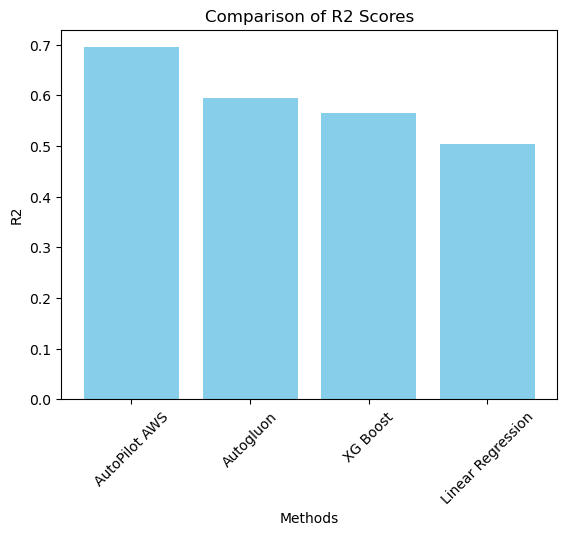

In [ ]:
import matplotlib.pyplot as plt

data = {
    "Linear Regression": 0.5035,
    "Autogluon": 0.5945,
    "XG Boost": 0.5654,
    "AutoPilot AWS": 0.6946
}

# Sort the data by descending R2 values
sorted_data = sorted(data.items(), key=lambda x: x[1], reverse=True)

methods = [method for method, _ in sorted_data]
r2_values = [r2 for _, r2 in sorted_data]

plt.bar(methods, r2_values, color='skyblue')
plt.xlabel('Methods')
plt.ylabel('R2')
plt.title('Comparison of R2 Scores')
plt.xticks(rotation=45)
plt.show()


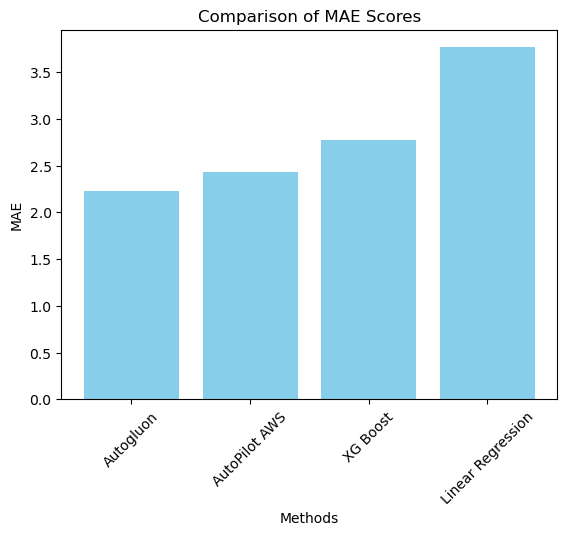

In [ ]:
data = {
    "Linear Regression": 3.7623,
    "Autogluon": 2.23,
    "XG Boost": 2.778,
    "AutoPilot AWS": 2.433
}

# Sort the data by ascending MAE values
sorted_data = sorted(data.items(), key=lambda x: x[1])

methods = [method for method, _ in sorted_data]
mae_values = [mae for _, mae in sorted_data]

plt.bar(methods, mae_values, color='skyblue')
plt.xlabel('Methods')
plt.ylabel('MAE')
plt.title('Comparison of MAE Scores')
plt.xticks(rotation=45)
plt.show()

In terms of MAE, the best results were obtained with Autogluon, with a relatively small difference over autopilot aws. However, in terms of r2, the best results were obtained with autopilot aws, with a significant difference over autogluon. Since autopilot aws is easier to deploy, it's best model will be deployed.

## 5) Deployment

### 5.1 Deploy best performing model of autopilot

In [ ]:
# Gettings candidate names
candidates = sm.list_candidates_for_auto_ml_job(AutoMLJobName=auto_ml_job_name,
                                                SortBy='FinalObjectiveMetricValue')['Candidates']
index = 1
for candidate in candidates:
  print (str(index) + "  "
         + candidate['CandidateName'] + "  "
         + str(candidate['FinalAutoMLJobObjectiveMetric']['Value']))
  index += 1

1  automl-fb-preds-20230831-05-45A1-003-3185663f  0.6051899790763855
2  automl-fb-preds-20230831-05-45A1-001-96a3d5b6  0.5642600059509277
3  automl-fb-preds-20230831-05-45A1-002-d7629e6d  0.5642499923706055
4  automl-fb-preds-20230831-05-45A1-004-af87bb63  0.13330000638961792
5  automl-fb-preds-20230831-05-45A1-006-7bdd3481  0.1304900050163269
6  automl-fb-preds-20230831-05-45A1-005-e38053a7  0.12782999873161316
7  automl-fb-preds-20230831-05-45A1-010-3f80540c  -9.885766983032227
8  automl-fb-preds-20230831-05-45A1-008-779a684f  -17.177955627441406
9  automl-fb-preds-20230831-05-45A1-007-3899da17  -18.760147094726562
10  automl-fb-preds-20230831-05-45A1-009-0fff2032  -24.374332427978516


In [ ]:
# Getting best candidate name

best_candidate = sm.describe_auto_ml_job(AutoMLJobName=auto_ml_job_name)['BestCandidate']
best_candidate_name = best_candidate['CandidateName']

print("Candidate name: " + best_candidate_name)

Candidate name: automl-fb-preds-20230831-05-45A1-003-3185663f


In [ ]:
# Getting inference containers

for container in best_candidate['InferenceContainers']:
    print(container['Image'])
    print(container['ModelDataUrl'])
    print('-')

683313688378.dkr.ecr.us-east-1.amazonaws.com/sagemaker-sklearn-automl:2.5-1-cpu-py3
s3://sagemaker-us-east-1-187593362463/sagemaker/DEMO-fb-ads-predictor/output/automl-fb-preds-20230831-05-45/data-processor-models/automl-fb-preds-20230831-05-45-dpp0-1-b268cb1c20054d47a4e7cf72f/output/model.tar.gz
-
683313688378.dkr.ecr.us-east-1.amazonaws.com/sagemaker-xgboost:1.3-1-cpu-py3
s3://sagemaker-us-east-1-187593362463/sagemaker/DEMO-fb-ads-predictor/output/automl-fb-preds-20230831-05-45/tuning/automl-fb--dpp0-xgb/automl-fb-preds-20230831-05-45A1-003-3185663f/output/model.tar.gz
-


Deploying the best candidate, with Amazon SageMaker Model Monitor

 Deploying the best candidate, with Amazon SageMaker Model Monitor
Now that we have successfully completed the AutoML job on our dataset and visualized the trials, we can create a model from any of the trials with a single API call and then deploy that model for online or batch prediction using Inference Pipelines. Let's create a SageMaker model for this Inference Pipeline.

In [ ]:
model_name = 'automl-dm-model-' + timestamp_suffix

model_arn = sm.create_model(Containers=best_candidate['InferenceContainers'],
                            ModelName=model_name,
                            ExecutionRoleArn=role)

print('Model ARN: ', model_arn['ModelArn'])

Model ARN:  arn:aws:sagemaker:us-east-1:187593362463:model/automl-dm-model-20230831-05-45


Let's configure data capture.

In [ ]:
# Don't forget to update the bucket! It must be in the same region as SageMaker
s3_capture_path = 's3://jchapto-capture-us-east-1/' + model_name + '/'

print(s3_capture_path)

s3://jchapto-capture-us-east-1/automl-dm-model-20230831-05-45/


In [ ]:
data_capture_configuration = {
    "EnableCapture": True, # flag turns data capture on and off
    "DestinationS3Uri": s3_capture_path, # s3 location where captured data is saved
    "InitialSamplingPercentage": 100, # sampling rate to capture data. max is 100%
    "CaptureOptions": [
       {
            "CaptureMode": "Output" # The type of capture this option enables. Values can be: [Output/Input]
        },
        {
            "CaptureMode": "Input" # The type of capture this option enables. Values can be: [Output/Input]
        }
    ],
    "CaptureContentTypeHeader": {
       "CsvContentTypes": ["text/csv"], # headers which should signal to decode the payload into CSV format
       "JsonContentTypes": ["application/json"] # headers which should signal to decode the payload into JSON format
    }
}

As usual, we first create the endpoint configuration, and then the endpoint.

In [ ]:
# Endpoint configuration name
timestamp_suffix = strftime('%d-%H-%M-%S', gmtime())
epc_name = 'automl-dm-epc-' + timestamp_suffix
print('Endpoint configuration name:', epc_name)

ep_config = sm.create_endpoint_config(EndpointConfigName = epc_name,
                                      ProductionVariants=[{'InstanceType':'ml.m4.xlarge',
                                                           'InitialInstanceCount':1,
                                                           'ModelName':model_name,
                                                           'VariantName': 'AllTraffic'}],
                                      DataCaptureConfig = data_capture_configuration)

Endpoint configuration name: automl-dm-epc-31-06-58-45


In [ ]:
# Endpoint name
ep_name = 'automl-dm-ep-' + timestamp_suffix
variant_name = 'automl-dm-variant-' + timestamp_suffix
print('Endpoint name:', ep_name)

create_endpoint_response = sm.create_endpoint(EndpointName=ep_name,
                                              EndpointConfigName=epc_name)

Endpoint name: automl-dm-ep-31-06-58-45


In [ ]:
%%time
sm.get_waiter('endpoint_in_service').wait(EndpointName=ep_name)

resp = sm.describe_endpoint(EndpointName=ep_name)
status = resp['EndpointStatus']

print("Endpoint ARN   : " + resp['EndpointArn'])
print("Endpoint status: " + status)

Endpoint ARN   : arn:aws:sagemaker:us-east-1:187593362463:endpoint/automl-dm-ep-31-06-58-45
Endpoint status: InService
CPU times: user 7.72 s, sys: 7.91 s, total: 15.6 s
Wall time: 5min 1s


In [ ]:
# Make predictions on endpoint

# Replace with the endpoint name and region you've deployed the endpoint in
endpoint_name = 'automl-dm-ep-30-04-37-33'
region = 'us-east-1'

runtime = boto3.Session().client('sagemaker-runtime', region_name=region)

# Load your test data
# Replace 'your_test_data.csv' with your actual test data file
test_data = pd.read_csv('data_validation.csv')

# Remove any target column if present, as the endpoint doesn't require it
test_data = test_data.drop(columns=['actions'])

# Loop through each row in the test data
predictions = []
for index, row in test_data.iterrows():
    payload = ','.join([str(val) for val in row.values])
    response = runtime.invoke_endpoint(EndpointName=endpoint_name,
                                       ContentType='text/csv',
                                       Body=payload)
    result = response['Body'].read().decode('utf-8')
    predictions.append(float(result))

# 'predictions' now holds the predicted values for your test data
print(predictions)

[3.5894365310668945, 4.305952072143555, 4.964067459106445, 4.057511329650879, 3.1722280979156494, 2.525930643081665, 4.172919273376465, 3.250657796859741, 5.199215412139893, 3.8394839763641357, 5.752068996429443, 4.021181583404541, 5.507615089416504, 3.8123042583465576, 4.953094959259033, 3.3409335613250732, 3.6880061626434326, 6.603761196136475, 10.671025276184082, 12.776045799255371, 2.408215284347534, 1.9261090755462646, 2.7823326587677, 2.2413852214813232, 3.056647300720215, 2.4309096336364746, 3.16762638092041, 2.4846105575561523, 3.096947193145752, 2.380072832107544, 2.7142374515533447, 2.1785550117492676, 2.9700238704681396, 1.8047645092010498, 3.7460808753967285, 2.0135021209716797, 4.405806064605713, 2.067798137664795, 4.196714878082275, 2.002028465270996, 2.3351831436157227, 1.468247890472412, 2.817589044570923, 1.6735765933990479, 3.3946640491485596, 1.8205528259277344, 3.880950689315796, 1.917107343673706, 4.086950302124023, 1.9249343872070312, 3.9160332679748535, 1.8339412

## 5.2 Cleanup

The Autopilot job creates many underlying artifacts such as dataset splits, preprocessing scripts, or preprocessed data, etc. This code, when un-commented, deletes them.

In [ ]:
#s3 = boto3.resource("s3")
#s3_bucket = s3.Bucket(bucket)

#print(s3_bucket)
#job_outputs_prefix = "{}/output/{}".format(prefix, auto_ml_job_name)
#print(job_outputs_prefix)

# Delete S3 objects
#s3_bucket.objects.filter(Prefix=job_outputs_prefix).delete()

We then delete all the experiment and model resources created by the Autopilot experiment.

In [ ]:
#def cleanup_experiment_resources(experiment_name):
 #   trials = sm.list_trials(ExperimentName=experiment_name)["TrialSummaries"]
  #  print("TrialNames:")
   # for trial in trials:
    #    trial_name = trial["TrialName"]
     #   print(f"\n{trial_name}")
#
 #       components_in_trial = sm.list_trial_components(TrialName=trial_name)
  #      print("\tTrialComponentNames:")
   #     for component in components_in_trial["TrialComponentSummaries"]:
    #        component_name = component["TrialComponentName"]
     #       print(f"\t{component_name}")
      #      sm.disassociate_trial_component(TrialComponentName=component_name, TrialName=trial_name)
       #     try:
        #        # comment out to keep trial components
         #       sm.delete_trial_component(TrialComponentName=component_name)
          #  except:
           #     # component is associated with another trial
            #    continue
            # to prevent throttling
       #     time.sleep(5)
     #   sm.delete_trial(TrialName=trial_name)
   # sm.delete_experiment(ExperimentName=experiment_name)
   # print(f"\nExperiment {experiment_name} deleted")


# def cleanup_autopilot_models(autopilot_job_name):
 #   print("{0}:\n".format(autopilot_job_name))
  #  response = sm.list_models(NameContains=autopilot_job_name)

   # for model in response["Models"]:
    #    model_name = model["ModelName"]
     #   print(f"\t{model_name}")
      #  sm.delete_model(ModelName=model_name)
        # to prevent throttling
       # time.sleep(3)

In [ ]:
#cleanup_experiment_resources("{0}-aws-auto-ml-job".format(auto_ml_job_name))

In [ ]:
#cleanup_autopilot_models(auto_ml_job_name)

Finally, the following code, when uncommented, will delete the local files used in this demo.

In [ ]:
#import shutil
#import glob
#import os


#def delete_local_files():
 #   base_path = ""
  #  dir_list = glob.iglob(os.path.join(base_path, "{0}*".format(auto_ml_job_name)))

   # for path in dir_list:
    #    if os.path.isdir(path):
     #       shutil.rmtree(path)

  #  if os.path.exists("CaliforniaHousing"):
   #     shutil.rmtree("CaliforniaHousing")

  #  if os.path.exists("cal_housing.tgz"):
    #    os.remove("cal_housing.tgz")

  #  if os.path.exists("SageMakerAutopilotCandidateDefinitionNotebook.ipynb"):
   #     os.remove("SageMakerAutopilotCandidateDefinitionNotebook.ipynb")

  #  if os.path.exists("SageMakerAutopilotDataExplorationNotebook.ipynb"):
   #     os.remove("SageMakerAutopilotDataExplorationNotebook.ipynb")

  #  if os.path.exists("test_data_no_target.csv"):
   #     os.remove("test_data_no_target.csv")

  #  if os.path.exists("test_data.csv"):
   #     os.remove("test_data.csv")

   # if os.path.exists("train_data.csv"):
    #    os.remove("train_data.csv")


## UNCOMMENT TO CLEAN UP LOCAL FILES
# delete_local_files()

**Note: If you enabled automatic endpoint creation, you will need to delete the endpoint manually.**